In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
class WeatherPreprocessor:
    def __init__(self):
        # Initial weather features for bike usage
        self.strike_feature = ["striker_ratio"]

    def merge_with_bike_data(self, bike_df, strikes_df):
        """Merge strikes data with bike count data"""

        # Round both datetime columns to hours for merging
        bike_df = bike_df.copy()
        bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('h')
        strikes_df['date'] = strikes_df['date'].dt.floor('h')

        # Merge datasets
        merged_df = pd.merge(
            bike_df,
            strikes_df,
            on='date',
            how='left'
        )

        return merged_df

def prepare_features_with_strike(bike_df, strikes_df):
    """Prepare complete feature set with strikes data"""
    # Initialize preprocessor
    preprocessor = WeatherPreprocessor()

    # Merge and preprocess data
    final_df = preprocessor.merge_with_bike_data(bike_df, strikes_df)

    # Select features for modeling
    strikes_features = ["striker_ratio"]

    return final_df, strikes_features

In [11]:
# Lire le fichier csv
bike_df = pd.read_csv(Path("../../bike_df.csv"))

strikes_df = pd.read_csv('Propre_strikes.csv')

strikes_df['date'] = pd.to_datetime(strikes_df['date'])

# Prepare features
final_df, strikes_features = prepare_features_with_strike(bike_df, strikes_df)
print(strikes_features)
final_df.head()

['striker_ratio']


,date,latitude,longitude,hour_sin,hour_cos,month_sin,month_cos,is_weekend,is_holiday,is_holiday_sco,is_working_day,is_rush_hour,counter_name,weekday,log_bike_count,striker_ratio
0,2020-09-01 02:00:00,48.846028,2.375429,0.500000,8.660254e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,0.000000,0.0
1,2020-09-01 03:00:00,48.846028,2.375429,0.707107,7.071068e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,0.693147,0.0
2,2020-09-01 04:00:00,48.846028,2.375429,0.866025,5.000000e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,0.000000,0.0
3,2020-09-01 15:00:00,48.846028,2.375429,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,1.609438,0.0
4,2020-09-01 18:00:00,48.846028,2.375429,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,False,False,False,True,True,28 boulevard Diderot E-O,Tuesday,2.302585,0.0


In [12]:
final_df.shape

(496827, 16)

In [13]:
final_df.dtypes

date              datetime64[ns]
latitude                 float64
longitude                float64
hour_sin                 float64
hour_cos                 float64
month_sin                float64
month_cos                float64
is_weekend                  bool
is_holiday                  bool
is_holiday_sco              bool
is_working_day              bool
is_rush_hour                bool
counter_name              object
weekday                   object
log_bike_count           float64
striker_ratio            float64
dtype: object

C:\Users\cleme\AppData\Local\Temp\ipykernel_7444\969918598.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features,


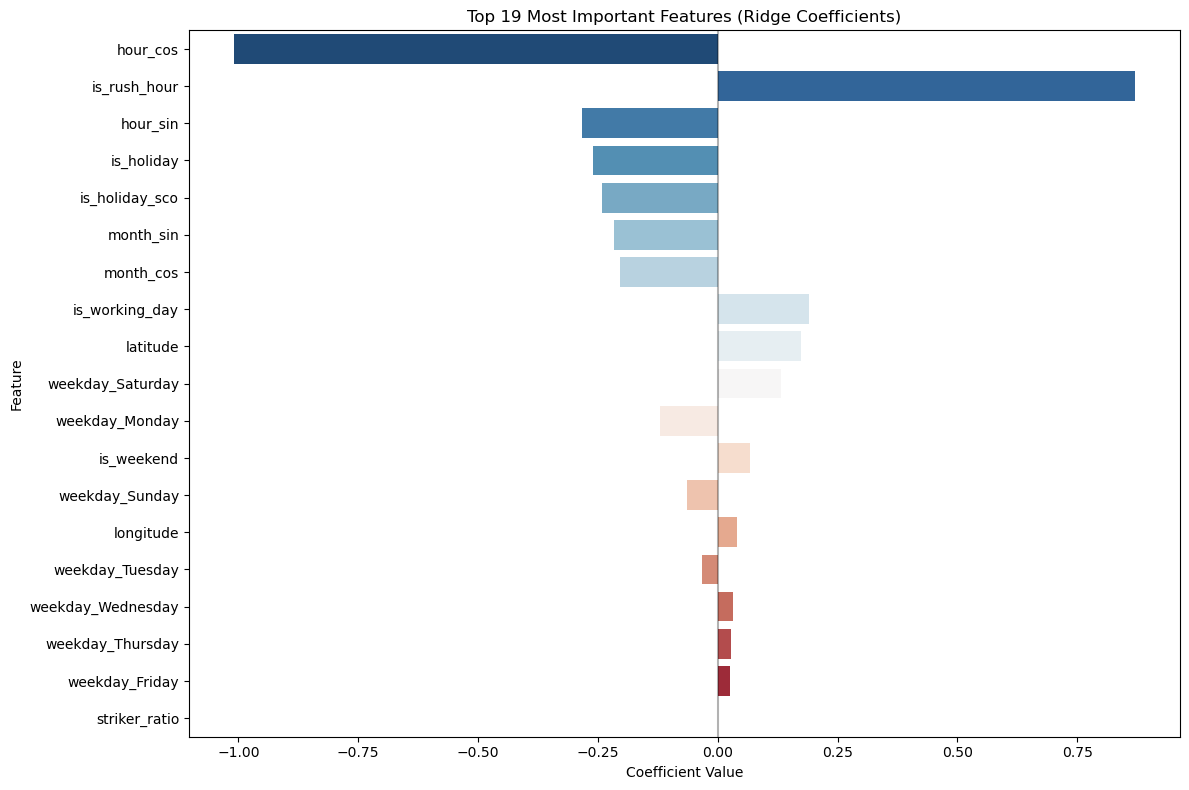

In [17]:
class RidgeFeatureAnalyzer:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            "striker_ratio"]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco',
            'is_working_day',
            'is_rush_hour']

        self.categorical_features = [
            'counter_name',
            'weekday'
        ]

    def create_pipeline(self, alpha=1.0):
        """Create preprocessing and Ridge pipeline"""
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=alpha))
        ])

    def analyze_feature_importance(self, X, y, alpha=1.0):
        """Analyze feature importance using Ridge regression"""
        # Fit pipeline
        pipeline = self.create_pipeline(alpha=alpha)
        pipeline.fit(X, y)

        # Get feature names after preprocessing
        feature_names = (
            self.numeric_features +
            pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(self.categorical_features).tolist() +
            self.binary_features
        )

        # Get coefficients
        coefficients = pipeline.named_steps['regressor'].coef_

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        })

        # Sort by absolute coefficient value
        importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

        return importance_df

    def plot_feature_importance(self, importance_df, top_n=19):
        """Plot feature importance"""
        plt.figure(figsize=(12, 8))

        # Plot top N features
        top_features = importance_df[~importance_df['feature'].str.contains('counter_name')].head(top_n)

        # Create bar plot
        sns.barplot(data=top_features,
                   y='feature',
                   x='coefficient',
                   palette='RdBu_r')

        plt.title(f'Top {top_n} Most Important Features (Ridge Coefficients)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Define feature groups
numeric_features = [
    'latitude',
    'longitude',
    'hour_sin',
    'hour_cos',
    'month_sin',
    'month_cos',
    "striker_ratio"
]

# Binary features don't need encoding
binary_features = [
    'is_weekend',
    'is_holiday',
    'is_holiday_sco',
    'is_working_day',
    'is_rush_hour'
    ]

# Categorical features need one-hot encoding
categorical_features = [
    'counter_name',
    'weekday'  # both cyclic and categorical representation
]

X = final_df[numeric_features + categorical_features + binary_features]
y = final_df['log_bike_count']

analyzer = RidgeFeatureAnalyzer()

# Basic feature importance analysis
importance_df = analyzer.analyze_feature_importance(X, y, alpha=1.0)
analyzer.plot_feature_importance(importance_df)